In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
!wget --no-check-certificate https://download.pytorch.org/tutorial/hymenoptera_data.zip

import zipfile

zip_file = 'hymenoptera_data.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall('./data')
zip_ref.close()

!rm hymenoptera_data.zip
#주소로 다운로드 받아 압축을 푼다

--2022-08-17 02:54:21--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.106, 99.86.38.72, 99.86.38.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.106|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  38.5MB/s    in 1.2s    

2022-08-17 02:54:22 (38.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#디스크에 저장된 데이터를 메인 메모리(main-memory)로 로드(load)하는 과정이 필요

# torchvision.datasets.ImageFolder를 호출하면 갖춰진 데이터 폴더 구조로부터 
#PyTorch dataset을 만들어 준다.

#ImageFolder 메소드는 ants / bees가 속한 train 폴더로부터 train dataset을, 
#ants / bees가 속한 val 폴더로부터 validation dataset을 자동으로 만들어줄 것이다.


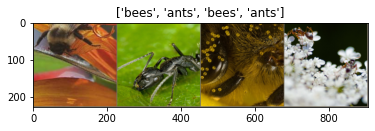

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
model_ft = models.resnet18(pretrained=True)
#pretrained model을 가져온다.

for param in model_ft.parameters():
    param.requires_grad = False
 # False로 설정함으로써 마지막 classifier를 제외한 모든 부분을 고정하여\
 # backward()중에 경사도 계산이 되지 않도록 

num_ftrs = model_ft.fc.in_features 
# ResNet18모델의 마지막 단에서, 출력 노드의 갯수를 구해주는 함수이다.

model_ft.fc = nn.Linear(num_ftrs, 2) 
# 이렇듯 Pretrained-model의 끝단에 Fully connected layer를 추가로 삽입하고 \
#노드를 연결시켜 주는 것이 우리가 사용할 모델

# 본 예제에서는 Fully connected layer \
#즉 Linear layer의 출력 노드 갯수는 Class의 갯수와 같다.(개미와 벌 == 2)

model_ft = model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Learning Rate Scheduler를 사용하면 좀 더 효율적으로 Global Minimam에 수렴할 수 있다.
# 예를 들면 특정 Epoch마다 Learning Rate를 다르게 해서 좀 더 효율 적으로 Global minima
# 에 수렴할 수 있도록 도와준다. 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time() # 시작 시간을 기록(총 소요 시간 계산을 위해)

    # fc를 초기화한 model의 parameter를 저장 
    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_acc = 0.0

    #지정한 epoch을 돌며 training
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1)) #epoch를 카운트 
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']: # train mode와 validation mode순으로 진행
            if phase == 'train':
                model.train()  # 모델을 train 모드로 설정
            else:
                model.eval()   # 모델을 eval(=val) 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 Gradiant를 0으로 초기화
                optimizer.zero_grad()

                # 순전파(foward)
                # 학습 시(train)에만 연산 기록을 추적
                # train의 경우 끝 fc부분만 진행이된다. 
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            # val을 수행하고 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model
    #코드에서 보면 확인할 수 있듯이 학습과 검사를 동시에 진행을 하여 epoch마다 \
    #Training acc와 Test acc를 확인할 수 있습니다.  최적의 epoch값을 찾기에 좋은 것 같습니다. 

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7632 Acc: 0.6025
val Loss: 0.4419 Acc: 0.7843

Epoch 1/24
----------
train Loss: 0.4368 Acc: 0.7869
val Loss: 0.2682 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.7865 Acc: 0.6803
val Loss: 0.1618 Acc: 0.9542

Epoch 3/24
----------
train Loss: 0.6329 Acc: 0.7705
val Loss: 0.1837 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4358 Acc: 0.8033
val Loss: 0.3563 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4207 Acc: 0.8566
val Loss: 0.1843 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.4624 Acc: 0.8156
val Loss: 0.4775 Acc: 0.8105

Epoch 7/24
----------
train Loss: 0.5466 Acc: 0.7992
val Loss: 0.1834 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.4307 Acc: 0.8115
val Loss: 0.2098 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2891 Acc: 0.8689
val Loss: 0.1721 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4275 Acc: 0.7951
val Loss: 0.1790 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3196 Acc: 0.8484
val Loss: 0.1758 Acc: 0.9542

Ep

In [ ]:
#Visualizing the model predictions
#Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Finetuning the convnet**
#Load a pretrained model and reset final fully connected layer.

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6693 Acc: 0.6393
val Loss: 0.2076 Acc: 0.9477

Epoch 1/24
----------
train Loss: 0.4294 Acc: 0.8238
val Loss: 0.2239 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.6654 Acc: 0.7828
val Loss: 0.1984 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4059 Acc: 0.8156
val Loss: 0.2972 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3856 Acc: 0.8443
val Loss: 0.3292 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.4276 Acc: 0.8279
val Loss: 0.2655 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.6732 Acc: 0.7664
val Loss: 0.1958 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4391 Acc: 0.8566
val Loss: 0.1734 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3793 Acc: 0.8648
val Loss: 0.1900 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.3884 Acc: 0.8443
val Loss: 0.1881 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3752 Acc: 0.8525
val Loss: 0.1683 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3977 Acc: 0.8525
val Loss: 0.1818 Acc: 0.9412

Ep

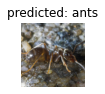

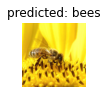

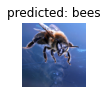

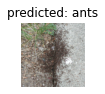

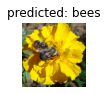

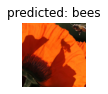

In [ ]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad = False to freeze the parameters so that the gradients are not computed in backward().


In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
#((Train and evaluate))
#On CPU this will take about half the time compared to previous scenario. 
#This is expected as gradients don't need to be computed for most of the network. 
#However, forward does need to be computed.

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7092 Acc: 0.6516
val Loss: 0.4007 Acc: 0.8366

Epoch 1/24
----------
train Loss: 0.5855 Acc: 0.7787
val Loss: 0.2108 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.6198 Acc: 0.7623
val Loss: 0.2383 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5043 Acc: 0.7623
val Loss: 0.1627 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.4640 Acc: 0.7910
val Loss: 0.1602 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4494 Acc: 0.7869
val Loss: 0.2287 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.5208 Acc: 0.7705
val Loss: 0.2169 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3611 Acc: 0.8525
val Loss: 0.2046 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3731 Acc: 0.8443
val Loss: 0.2100 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3544 Acc: 0.8566
val Loss: 0.2437 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3361 Acc: 0.8566
val Loss: 0.2096 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3115 Acc: 0.8689
val Loss: 0.2034 Acc: 0.9477

Ep

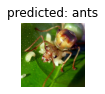

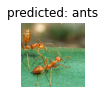

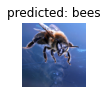

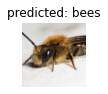

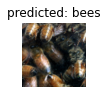

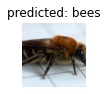

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()